In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import sounddevice as sd

In [2]:
import matplotlib.pyplot as plt
from IPython import display
from tensorflow.keras import layers
from tensorflow.keras import models
%matplotlib inline

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
sources = ["acoustic", "electronic", "synthetic"]
families = ["bass", "brass", "flute", "guitar", "keyboard", "mallet", "organ", "reed", "string", "synth_lead", "vocal"]

In [21]:
spectrograms_train = tf.saved_model.load("data/processed/spectrograms_train").read_value()
spectrograms_test = tf.saved_model.load("data/processed/spectrograms_test").read_value()
labels_train = tf.saved_model.load("data/processed/labels_train").read_value()
labels_test = tf.saved_model.load("data/processed/labels_test").read_value()

In [22]:
audio_train = tf.saved_model.load("data/processed/audio_train").read_value()
audio_test = tf.saved_model.load("data/processed/audio_test").read_value()

In [23]:
print(spectrograms_train.shape)
print(labels_train.shape)
print(spectrograms_test.shape)
print(labels_test.shape)
print(audio_train.shape)
print(audio_test.shape)

In [25]:
input_shape = spectrograms_train.shape[1:]
print('Input shape:', input_shape)
num_labels = len(families)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrograms_train)

model = models.Sequential([
    layers.Input(shape=(None, None, 1)),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (499, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [27]:
EPOCHS = 50
history = model.fit(
    x=spectrograms_train,
    y=labels_train,
    validation_data=(spectrograms_test, labels_test),
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/50
96/96 [==============================] - 26s 17ms/step - loss: 1.7563 - accuracy: 0.3607 - val_loss: 1.3638 - val_accuracy: 0.4795
Epoch 2/50
96/96 [==============================] - 1s 13ms/step - loss: 1.3089 - accuracy: 0.5107 - val_loss: 1.0565 - val_accuracy: 0.5752
Epoch 3/50
96/96 [==============================] - 1s 14ms/step - loss: 1.0369 - accuracy: 0.6120 - val_loss: 0.8837 - val_accuracy: 0.6768
Epoch 4/50
96/96 [==============================] - 1s 14ms/step - loss: 0.9003 - accuracy: 0.6621 - val_loss: 0.7692 - val_accuracy: 0.7188
Epoch 5/50
96/96 [==============================] - 1s 13ms/step - loss: 0.7979 - accuracy: 0.7074 - val_loss: 0.6684 - val_accuracy: 0.7744
Epoch 6/50
96/96 [==============================] - 1s 13ms/step - loss: 0.6827 - accuracy: 0.7487 - val_loss: 0.6056 - val_accuracy: 0.7705
Epoch 7/50
96/96 [==============================] - 1s 13ms/step - loss: 0.6199 - accuracy: 0.7852 - val_loss: 0.5526 - val_accuracy: 0.8154
Epoch 8/50
9

Text(0, 0.5, 'Accuracy [%]')

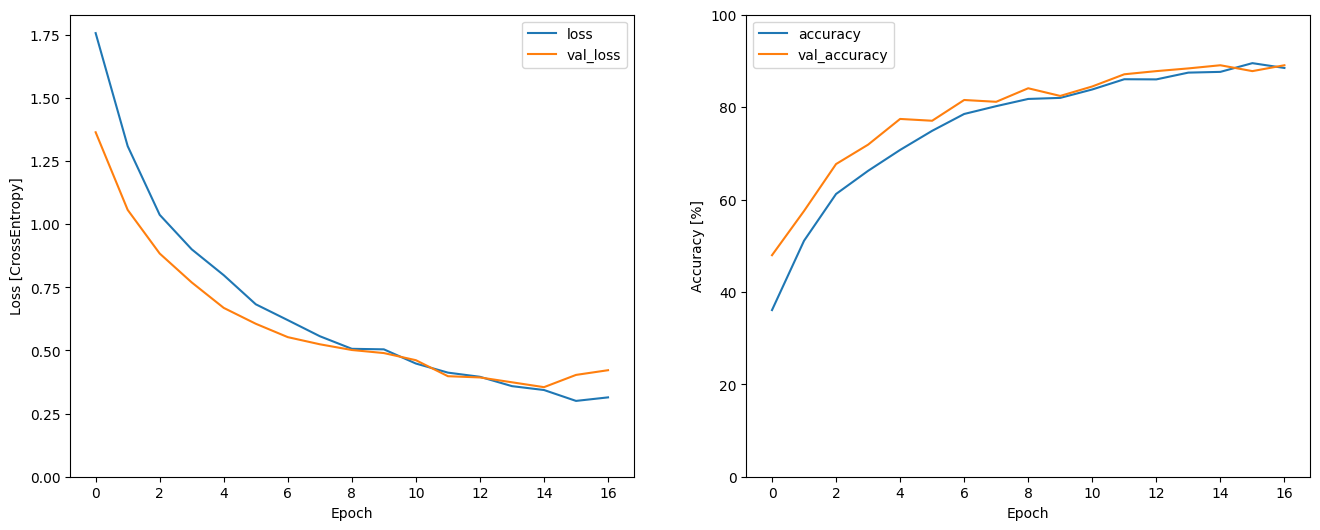

In [28]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [29]:
model.save("./models/model2")

INFO:tensorflow:Assets written to: ./models/model2\assets


INFO:tensorflow:Assets written to: ./models/model2\assets


In [30]:
model = tf.keras.models.load_model("./models/model2")

In [44]:
x = tf.io.read_file("./samples/piano-G3.wav")
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

In [45]:
prediction = model(x)

In [46]:
prediction

<tf.Tensor: shape=(1, 11), dtype=float32, numpy=
array([[ 1.5312138 , -2.5981364 , -0.73002565,  0.48466676,  2.4094381 ,
         0.8876189 , -0.5535162 , -3.757273  , -1.843349  , -6.57991   ,
        -3.4927995 ]], dtype=float32)>

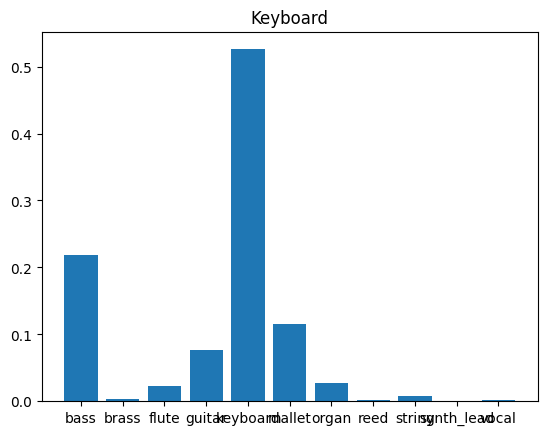

In [49]:
plt.bar(families, tf.nn.softmax(prediction[0]))
plt.title('Keyboard')
plt.show()

display.display(display.Audio(waveform, rate=16000))